# 02_reproduc_data_handling

Warning message in dir.create(write_output_base_path):
“'output/reproduc' already exists”Loading required package: colorblindr
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘colorblindr’”

named list()

named list()

X,x
1,1
2,4
3,15
4,16
5,26
6,58


[1] 2

Warning message:
“Column `Q3`/`DOI` joining character vector and factor, coercing into character vector”Warning message:
“Column `Q3`/`DOI` joining character vector and factor, coercing into character vector”

[1] 20 20

[1] 360  20

[1] TRUE

[1] "Yes"                "Unfamiliar Methods" "Not Sure"          
[4] "No"

[1] "Yes"                                                                                                                             
[2] "Not sure (unclear materials.....hard to follow)"                                                                                 
[3] "I'm not familiar with the required computational resources.\n(specify required computational resources (e.g., R, Fortran, Linux)"
[4] "No"

[1] "Yes"                "Some"               "No"                
[4] "Availability\nFail"

[1] "Some"                                 
[2] "Yes"                                  
[3] "No (explain why on the next question)"
[4] "Avail Fail"

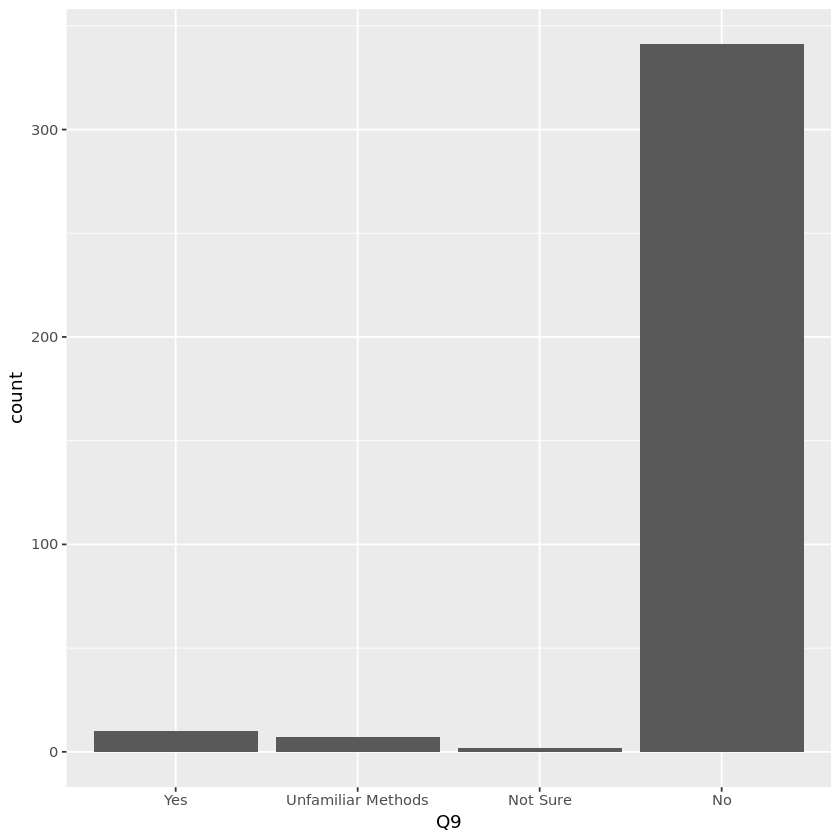

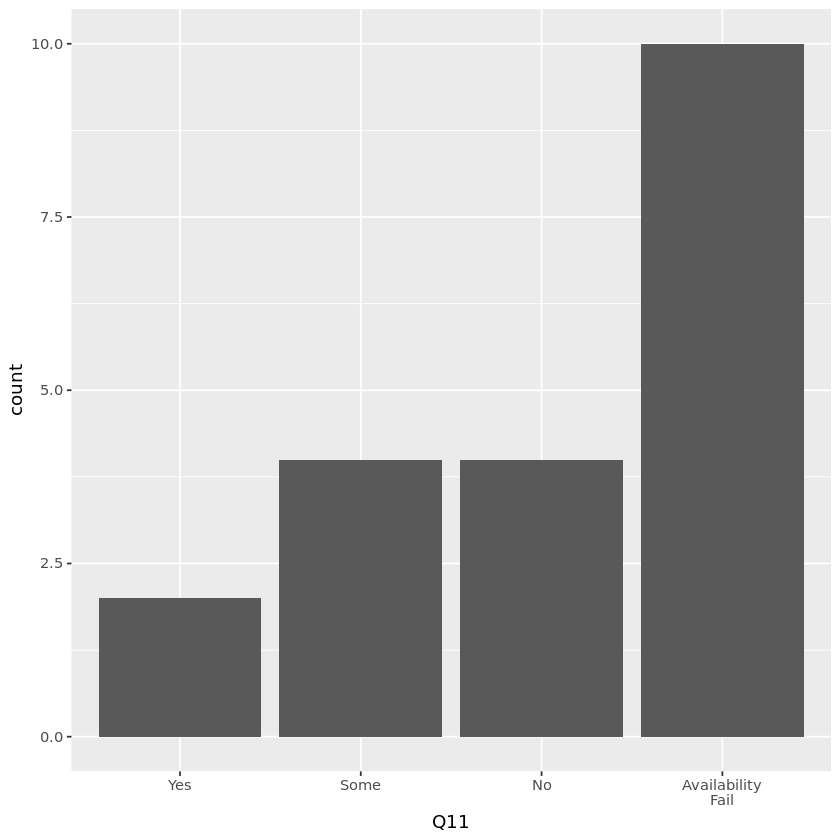

In [3]:
# *------------------------------------------------------------------
# | PROGRAM NAME: 03_ap_model_fit
# | FILE NAME: 03_ap_model_fit.R
# | DATE: 
# | CREATED BY:  Jim Stagge         
# *----------------------------------------------------------------
# | PURPOSE:  This is a code wrapper to fit the Annual Percentile (AP) model.
# | It fits cumulative probability distributions for annual and monthly flows.
# |
# |
# *------------------------------------------------------------------
# | COMMENTS:               
# |
# |  1:  
# |  2: 
# |  3: 
# |*------------------------------------------------------------------
# | DATA USED:               
# | USGS gauge flow data
# | Annual reconstructions from:
# | Allen, E.B., Rittenour, T.M., DeRose, R.J., Bekker, M.F., Kjelgren, R., Buckley, B.M., 2013. A tree-ring based reconstruction of Logan River streamflow, northern Utah. Water Resources Research 49, 8579–8588. doi:10.1002/2013WR014273.
# |
# | DeRose, R.J., Bekker, M.F., Wang, S.Y., Buckley, B.M., Kjelgren, R.K., Bardsley, T., Rittenour, T.M., Allen, E.B., 2015. A millennium-length reconstruction of Bear River stream flow, Utah. Journal of Hydrology 529, Part 2, 524–534. doi:10.1016/j.jhydrol.2015.01.014.
# |
# |*------------------------------------------------------------------
# | CONTENTS:               
# |
# |  PART 1:  
# |  PART 2: 
# |  PART 3: 
# *-----------------------------------------------------------------
# | UPDATES:               
# |
# |
# *------------------------------------------------------------------

### Clear any existing data or functions.
rm(list=ls())

###########################################################################
## Set the Paths
###########################################################################
### Path for Data and Output	
data_path <- "data"
output_path <- "output"
global_path <- "../global_func"
function_path <- "./functions"

### Set output location
output_name <- "reproduc"
write_output_base_path <- file.path(output_path, output_name)

dir.create(write_output_base_path)

### Set input location
data_path<- file.path(data_path)

###########################################################################
###  Load functions
###########################################################################
### Load these functions for all code
require(colorout)
require(assertthat)
require(staggefuncs)
require(tidyverse)
require(colorblindr)

### Load these functions for this unique project
require(stringr)

### Fix the select command
select <- dplyr::select

### Load project specific functions
file.sources = list.files(function_path, pattern="*.R", recursive=TRUE)
sapply(file.path(function_path, file.sources),source)

### Load global functions
file.sources = list.files(global_path, pattern="*.R", recursive=TRUE)
sapply(file.path(global_path, file.sources),source)



###########################################################################
## Set Initial Values
###########################################################################

journal_abbrev <- c("EM&S", "HESS", "JoH", "JAWRA", "JWRP&M", "WRR")
journal_colors <- cb_pal("custom", n=6, sort=FALSE)

###########################################################################
## Set Additional Output Folders
###########################################################################
### Set up output folders
write_figures_path <- file.path(write_output_base_path, "figures")
dir.create(file.path(write_figures_path,"png"), recursive=TRUE)
dir.create(file.path(write_figures_path,"pdf"), recursive=TRUE)
dir.create(file.path(write_figures_path,"svg"), recursive=TRUE)

###########################################################################
###  Read in Data
###########################################################################

### Read in reproducibility data
read_location <- file.path(data_path, "Reproducibility_Results_edits.csv")

reproduc_df <- read.csv(file = read_location)

### Consider trying the function str_clean()  from explarotaory packages to clean up \n and things like that

### Can use this to pull out comma delimited data into separate rows
#mutate(`Select Investors` = str_split(`Select Investors`, ", "))
#unnest(`Select Investors`)

###########################################################################
###  Fix http in Q3
###########################################################################
### Remove doi.org/
### Remove https://doi.org/
reproduc_df$Q3 <- str_replace(reproduc_df$Q3, "https://", "")
reproduc_df$Q3 <- str_replace(reproduc_df$Q3, "doi.org/", "")
reproduc_df$Q3 <- as.character(reproduc_df$Q3)
 

###########################################################################
###  Read in publication summary table
###########################################################################
pub_summary_table <- read.csv(file.path(write_output_base_path, "articles/pub_summary_table.csv"))

### Add  publication abbreviations to publication summary table
pub_summary_table$journal_abbrev <- factor(pub_summary_table$journal_abbrev, levels=journal_abbrev)


###########################################################################
###  Add keywords
###########################################################################
### Read in Papers
paper_assign <- read.csv(file.path(write_output_base_path, "articles/paper_assign.csv"))
sampled_keywords <- read.csv(file.path(write_output_base_path, "articles/sampled_keywords.csv"))
sampled_nonkeywords <- read.csv(file.path(write_output_base_path, "articles/sampled_nonkeywords.csv"))

head(sampled_nonkeywords)

### Create a column for keyword selection and merge into a single dataframe
sampled_nonkeywords$keyword <- FALSE
sampled_keywords$keyword <- TRUE
sampled_df <- rbind(sampled_nonkeywords, sampled_keywords)

### Join the paper assignments with keyword column based on index
paper_assign_merge <- paper_assign %>% 
	left_join(sampled_df, by = c("index" = "x")) %>%
	select(DOI, keyword)

### Check and remove duplicate DOIs
dup_doi <- duplicated(paper_assign_merge$DOI)
paper_assign_merge <- paper_assign_merge[!dup_doi,]
sum(dup_doi)
### There is one paper (Isakov) that was sampled twice
rm(dup_doi)

### Merge back with reproduc_df to add keyword column
reproduc_df <- reproduc_df %>%
	left_join(paper_assign_merge, by = c("Q3" = "DOI"))
	
### Check missing DOIs
check_df <- reproduc_df %>%
	full_join(paper_assign_merge, by = c("Q3" = "DOI"))

missing_doi <- paper_assign_merge$DOI[!(paper_assign_merge$DOI %in% reproduc_df$Q3)]
missing_papers <- paper_assign[paper_assign$DOI %in% missing_doi, ]

### Output to csv
write.csv(missing_papers, file.path(write_output_base_path, "missing_papers.csv"))


###########################################################################
###  Separate into availability only and reproducibility 
###########################################################################
### Create test based on manually created reproducibility/availability column
reproduc_test <- reproduc_df$rep_avail == "repro"

### Separate reproduc from availability only 
reproduc_only <- reproduc_df[reproduc_test,]
avail_only <- reproduc_df[!reproduc_test,]

dim(reproduc_only)
dim(avail_only)

###########################################################################
###  Check for duplicates
###########################################################################
duplicate_avail <- avail_only %>% 
	group_by(Q3) %>% 
	filter(n()>1) %>% 
	summarize(n=n(), Reviewer=Q1[1], Title=Q4[1]) %>%
	arrange(Reviewer, Q3) %>%
	as.data.frame
	
duplicate_reproduc <- reproduc_only %>% 
	group_by(Q3) %>% 
	filter(n()>1) %>% 
	summarize(n=n(), Reviewer=Q1[1], Title=Q4[1]) %>%
	arrange(Reviewer, Q3) %>%
	as.data.frame

### Combine into one	
duplicate_df <- rbind(duplicate_avail, duplicate_reproduc)

### Output to csv
write.csv(duplicate_df, file.path(write_output_base_path, "duplicates_by_number.csv"))

### Remove individual dataframes
rm(duplicate_avail)
rm(duplicate_reproduc)

duplicate_full <- reproduc_df[reproduc_df$Q3 %in% duplicate_df$Q3,] %>%
	arrange(Q3)

### Output to csv
write.csv(duplicate_full, file.path(write_output_base_path, "duplicates_full.csv"))


###########################################################################
###  Bring reproducibility and availability back together
###########################################################################
reproduc_df <- rbind(avail_only, reproduc_only)

### Remove individual dataframes
rm(avail_only, reproduc_only)

###########################################################################
###  Note to self regarding questions
###########################################################################
# Q2 = journal
# Q3 = doi
# Q4 = citation
# Q5 = Some or all available?*** Data-less? Not specified?
# Q6 = Author request, third party, available only in article, Some or all found online*** [[[Comma separated column, can be multiples]]]
# Q7 = ***Directions to run, Code/Model/Software, Input Data,      Hardware/Software requirements, File format, instructions to open [[[Comma separated column]]]
# Q8 = comments
# Q9 = Do I think i can do it: yes**, no, not sure**, not familiar with computational**
# Q10 = Do I continue with reproducibility analysis?
# Q11 = Can results be reproduced?
# Q12 = How long did it take?
# Q13 = Why did reproducibility fail?


###########################################################################
###  Process Q2 - Journal Abbreviation
###########################################################################
### Create a column of journal abbreviations
journal_names <- levels(reproduc_df$Q2)
reproduc_df$Q2_abbrev <- factor(reproduc_df$Q2, levels=journal_names, labels=journal_abbrev)

###########################################################################
###  Process Q5 - "Availability Claim"
###########################################################################
### Create a column of simplified Q5
q5_levels <- levels(reproduc_df$Q5)
reproduc_df$Q5 <- factor(reproduc_df$Q5, levels=q5_levels, labels=c("Dataless or review", "No availability", "Some or all available"))

###########################################################################
###  Process Q6 - "Availability Source"
###########################################################################
q6_labels <- c("Some or All\nAvailable Online", "Only In\nArticle", "Author\nRequest", "Third\nParty", "None")

### Create columns for each of the sources
q6_df <- reproduc_df %>% 
	dplyr::select(Q2_abbrev, Q3, Q6, rep_avail) %>%
	mutate(some = str_detect(Q6, "online"))  %>%
	mutate(article = str_detect(Q6, "figures/tables/text")) %>%
	mutate(author = str_detect(Q6, "Author")) %>%
	mutate(third = str_detect(Q6, "Third"))

### Create a column for none
q6_df$none <- q6_df %>% 
	dplyr::select(-Q2_abbrev, -Q3, -Q6, -rep_avail) %>%
	apply(., 1, sum) == 0

### Summarize, count number of each, grouped per journal, perform only for availability test
### Only consider the first pass (availability or reproducibility step)
q6_journal_count <- q6_df %>%
	filter(rep_avail != "repro") %>%
	select(-Q6, -Q3) %>%
	group_by(Q2_abbrev) %>%
  	summarize(author = sum(author), article = sum(article), third = sum(third), some = sum(some), none = sum(none), n= n()) %>%
  	ungroup()

### Add a total row at the bottom
q6_journal_count <- q6_journal_count %>% 
  		dplyr::select(-Q2_abbrev) %>% 
  		summarise_all(funs(sum)) %>%
  		add_column(Q2_abbrev="Total", .before=1) %>%
  		rbind(q6_journal_count, .)	

### Divide by n to get percent in each category  	
q6_journal_perc  <- q6_journal_count %>%
  	mutate(author = author/n, article = article/n, third = third/n, some=some/n, none=none/n) %>%
  	dplyr::select(-n)

### Output to csv
write.csv(q6_journal_count, file.path(write_output_base_path, "q6_journal_count.csv"))
write.csv(q6_journal_perc, file.path(write_output_base_path, "q6_journal_perc.csv"))

### Create rules for how to classify Q6
q6_df$Q6_grouping <- NA
q6_df$Q6_grouping[q6_df$article == TRUE] <- "Only In\nArticle"
q6_df$Q6_grouping[q6_df$some == TRUE] <-  "Some or All\nAvailable Online"
### End with third party or authors because these trump, disqualify
q6_df$Q6_grouping[q6_df$third == TRUE] <-  "Third\nParty"
q6_df$Q6_grouping[q6_df$author == TRUE] <-  "Author\nRequest"
q6_df$Q6_grouping[q6_df$none == TRUE] <- "None"

### Put back into reproducability df
reproduc_df$Q6_grouping <- q6_df$Q6_grouping
reproduc_df$Q6_grouping <- factor(reproduc_df$Q6_grouping, levels=q6_labels)

### Data prep
#reproduc_df$Q6_grouping <- "No"
### If it contains Author Request at all
#reproduc_df$Q6_grouping[str_detect(reproduc_df$Q6, "Author")] <- "Author\nRequest"
### If it contains Tin article at all
#reproduc_df$Q6_grouping[str_detect(reproduc_df$Q6, "figures/tables")] <- "In\nArticle"
### If it contains Third Party Request at all (trumps Author Request)
#reproduc_df$Q6_grouping[str_detect(reproduc_df$Q6, "Third Party")] <- "Third\nParty"
### If available in paper
#reproduc_df$Q6_grouping[str_detect(reproduc_df$Q6, "online")] <- "Some or\nAll Available"

#reproduc_df$Q6_grouping <- factor(reproduc_df$Q6_grouping, levels=q6_labels)



###########################################################################
###  Process Q7 - "Available Components"
###########################################################################
#Directions to run
#Code/Model/Software
#Input data

#Hardware/Software requirements
#Materials linked by unique and persistent identifiers
#Metadata to describe the code
#Common file format /instructions to open
q7_df  <- data.frame(Q3=reproduc_df$Q3, Q7=reproduc_df$Q7)

### Test for each of the primary answers
q7_df$dir <- str_detect(reproduc_df$Q7, "Directions to run")
q7_df$code <- str_detect(reproduc_df$Q7, "Code/Model/Software")
q7_df$data <- str_detect(reproduc_df$Q7, "Input data")

### Count number of primary
q7_df$primary_n <- q7_df %>% 
	dplyr::select(c("dir", "code", "data")) %>%
	rowSums(.)

### Test for all primary
q7_df$primary <- q7_df$primary_n == 3	

### Test for each of the secondary answers
q7_df$hardw <- str_detect(reproduc_df$Q7, "Hardware/Software requirements")
q7_df$doi <- str_detect(reproduc_df$Q7, "Materials linked by unique and persistent identifiers")
q7_df$meta <- str_detect(reproduc_df$Q7, "Metadata to describe the code")
q7_df$common <- str_detect(reproduc_df$Q7, "Common file format /instructions to open")

### Count number of secondary
q7_df$secondary_n <- q7_df %>% 
	dplyr::select(c("hardw", "doi", "meta", "common")) %>%
	rowSums(.)
	
### Test for some of secondary
q7_df$secondary_some <- q7_df$secondary_n > 0	
q7_df$secondary_all <- q7_df$secondary_n == 4	

### Test for all
q7_df$all <- q7_df$primary == TRUE & q7_df$secondary_all == TRUE 

### Check that the DOIs in q7_df match original DOIs
assert_that(sum(q7_df$Q3 != reproduc_df$Q3) == 0)

### Merge back into reproduc_df
q7_df <- q7_df %>% dplyr::select(-Q7, -Q3)
names(q7_df) <- paste0("Q7_", names(q7_df))
reproduc_df <- cbind(reproduc_df, q7_df)


### Run analysis on q7
q7_df$Q2_abbrev <- reproduc_df$Q2_abbrev
q7_df$rep_avail <- reproduc_df$rep_avail

### Summarize, count number of each, grouped per journal
### Only consider the first pass (availability or reproducibility step)
q7_journal_count <- q7_df %>%
	### Only the availability portion of survey
	filter(rep_avail != "repro") %>%
	select(-Q7_primary_n, -Q7_primary, -Q7_secondary_n, -Q7_secondary_some, -Q7_secondary_all, -Q7_all) %>%
	### Group by journal
	group_by(Q2_abbrev) %>%
	### Count number of TRUEs in each category
  	summarize(dir = sum(Q7_dir), code = sum(Q7_code), data = sum(Q7_data), hardw = sum(Q7_hardw), doi = sum(Q7_doi), meta = sum(Q7_meta), common = sum(Q7_common), n= n()) %>%
  	ungroup()

### Add a total row at the bottom
q7_journal_count <- q7_journal_count %>% 
  		dplyr::select(-Q2_abbrev) %>% 
  		summarise_all(funs(sum)) %>%
  		add_column(Q2_abbrev="Total", .before=1) %>%
  		rbind(q7_journal_count, .)	

### Divide by n to get percent in each category  	
q7_journal_perc  <- q7_journal_count %>%
  	mutate(dir = dir/n, code = code/n, data = data/n, hardw = hardw/n, doi = doi/n, meta = meta/n, common = common/n) %>%
  	dplyr::select(-n)
  	
  	
###########################################################################
###  Process Q9 - "Availability Determination"
###########################################################################
# "I'm not familiar with the required computational resources.\n(specify required computational resources (e.g., R, Fortran, Linux)"
# "No"                                                                                                                              
# "Not sure (unclear materials.....hard to follow)"                                                                                 
# "Yes"

### Separate Q9    
q9_reframe <- as.character(reproduc_df$Q9)

### Convert NAs to No
q9_reframe[q9_reframe == ""] <- "No"

### Create labels and levels
q9_labels <- c("Yes", "Unfamiliar Methods", "Not Sure", "No")
q9_levels <- unique(q9_reframe)
q9_levels <- q9_levels[c(3,4,2,1)]
q9_labels
q9_levels

q9_reframe <- factor(q9_reframe, levels=q9_levels, labels=q9_labels)

### Factor q9
reproduc_df$Q9 <- q9_reframe

### Check plot
ggplot(subset(reproduc_df, rep_avail != "repro"), aes(x=Q9)) + geom_bar()


###########################################################################
###  Process Q11 - "Replicability Determination"
###########################################################################
### Separate Q11    
q11_reframe <- as.character(reproduc_df$Q11)

### Convert Emptys to Avail Failure
q11_reframe[q11_reframe == ""] <- "Avail Fail"

### Create labels and levels
q11_labels <- c("Yes", "Some", "No", "Availability\nFail")
q11_levels <- unique(q11_reframe)
q11_levels <- q11_levels[c(4,3,2,1)]
q11_labels
q11_levels

q11_reframe <- factor(q11_reframe, levels=q11_levels, labels=q11_labels)

### Factor q11
reproduc_df$Q11 <- q11_reframe

### Check plot
ggplot(subset(reproduc_df, rep_avail == "repro"), aes(x=Q11)) + geom_bar()


###########################################################################
###  Process Q13 - "Reproducibility Failure"
###########################################################################
q13_labels <- c("Unclear directions", "Results differed", "Did not generate results", "Hardware/software error", "Other", "None")

### Create columns for each of the sources
q13_df <- reproduc_df %>% 
	select(Q2_abbrev, Q3, Q13, rep_avail) %>%
	mutate(unclear = str_detect(Q13, "directions"))  %>%
	mutate(differ = str_detect(Q13, "differed")) %>%
	mutate(no_result = str_detect(Q13, "generate")) %>%
	mutate(hard_soft = str_detect(Q13, "error")) %>%
	mutate(other = str_detect(Q13, "Other"))

### Create a column for none
q13_df$none <- q13_df %>% 
	select(-Q2_abbrev, -Q3, -Q13, -rep_avail) %>%
	apply(., 1, sum) == 0

### Merge back into reproduc_df
q13_df <- q13_df %>% dplyr::select(-Q2_abbrev, -Q3, -Q13, rep_avail)
names(q13_df) <- paste0("Q13_", names(q13_df))
reproduc_df <- cbind(reproduc_df, q13_df)


### Run analysis on q7
q13_df$Q2_abbrev <- reproduc_df$Q2_abbrev
q13_df$rep_avail <- reproduc_df$rep_avail
q13_df$Q11 <- reproduc_df$Q11

q13_df$avail_fail <- FALSE
q13_df$avail_fail[q13_df$Q11 == "Availability\nFail"] <- TRUE
q13_df$none_corrected <- q13_df$Q13_none
q13_df$none_corrected[q13_df$Q11 == "Availability\nFail"] <- FALSE

### Summarize, count number of each, grouped per journal
### Only consider the first pass (availability or reproducibility step)
q13_journal_count <- q13_df %>%
	### Only the availability portion of survey
	filter(rep_avail == "repro") %>%
	#select(-Q7_primary_n, -Q7_primary, -Q7_secondary_n, -Q7_secondary_some, -Q7_secondary_all, -Q7_all) %>%
	### Group by journal
	group_by(Q2_abbrev) %>%
	### Count number of TRUEs in each category
  	summarize(unclear = sum(Q13_unclear), differ = sum(Q13_differ), no_result = sum(Q13_no_result), hard_soft = sum(Q13_hard_soft), other = sum(Q13_other), none= sum(none_corrected), avail_fail = sum(avail_fail), n= n()) %>%
  	ungroup()

### Add a total row at the bottom
q13_journal_count <- q13_journal_count %>% 
  		dplyr::select(-Q2_abbrev) %>% 
  		summarise_all(funs(sum)) %>%
  		add_column(Q2_abbrev="Total", .before=1) %>%
  		rbind(q13_journal_count, .)	

### Divide by n to get percent in each category  	
q13_journal_perc  <- q13_journal_count %>%
  	mutate(unclear= unclear/n, differ = differ/n, no_result = no_result/n, hard_soft = hard_soft/n, other = other/n, none = none/n, avail_fail = avail_fail/n) %>%
  	dplyr::select(-n)
  	
###########################################################################
###  Save progress
###########################################################################
save(reproduc_df, pub_summary_table, q6_labels, q6_journal_perc, q6_journal_count, q7_journal_perc, q7_journal_count, q9_labels, q11_labels, q13_labels, q13_journal_count, q13_journal_perc, file=file.path(write_output_base_path, "reproduc_data.rda"))


